<a href="https://colab.research.google.com/github/VectorNd/Dogs-Vs-Cats-Classification/blob/main/Cassandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle competitions download -c cassandra23-ps-2

cassandra23-ps-2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip /content/cassandra23-ps-2.zip -d cassandra/

Archive:  /content/cassandra23-ps-2.zip
replace cassandra/dataset/sample_submissions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cassandra/dataset/test_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cassandra/dataset/train_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


**Dataset Analysis**

In [10]:
import pandas as pd 

train_csv = pd.read_csv('/content/cassandra/dataset/train_data.csv')

In [11]:
test_csv = pd.read_csv('/content/cassandra/dataset/test_data.csv') 
Test_csv = test_csv.drop(columns = ['UID' , 'trip_creation_time' , 'route_schedule_uuid' ,'trip_uuid' , 'source_center' , 'destination_center' ,
                                      'od_start_time' , 'od_end_time' , 'cutoff_timestamp' , 'source_name' , 'destination_name']) 

Test_csv.shape

(72158, 12)

In [12]:
train_csv.isnull().sum()

UID                                   0
trip_creation_time                 3515
route_schedule_uuid                2895
route_type                            0
trip_uuid                             0
source_center                         0
source_name                           0
destination_center                  803
destination_name                      0
od_start_time                         0
od_end_time                         720
start_scan_to_end_scan                0
is_cutoff                             0
cutoff_factor                         0
cutoff_timestamp                    930
actual_distance_to_destination        0
osrm_time                         14432
osrm_distance                     14432
factor                             1644
segment_actual_time                   0
segment_osrm_time                     0
segment_osrm_distance                 0
segment_factor                     1159
actual_time                           0
dtype: int64

In [13]:
train_csv.shape

(72158, 24)

In [14]:
train_csv.duplicated().sum()

0

In [ ]:
Train_csv = train_csv.drop(columns = ['UID' , 'trip_creation_time' , 'route_schedule_uuid' ,'trip_uuid' , 'source_center' , 'destination_center' ,
                                      'od_start_time' , 'od_end_time' , 'cutoff_timestamp'])

Train_csv.head()

In [16]:
corr_matrix = Train_csv.corr()['actual_time'].sort_values(ascending = True)
corr_matrix 

segment_factor                    0.014070
factor                            0.032473
segment_actual_time               0.120842
segment_osrm_time                 0.163041
is_cutoff                         0.164992
segment_osrm_distance             0.226091
osrm_time                         0.721952
osrm_distance                     0.725394
start_scan_to_end_scan            0.774909
actual_distance_to_destination    0.968574
cutoff_factor                     0.979045
actual_time                       1.000000
Name: actual_time, dtype: float64

In [17]:
Train_csv.shape

(72158, 15)

In [18]:
# METHOD 1 

Train = Train_csv.dropna().drop(columns = ['source_name' , 'destination_name']) 
Train.shape

from sklearn.model_selection import train_test_split 
Train_set , Test_set = train_test_split(Train , test_size = 0.2 , random_state = 42)

# from sklearn.preprocessing import OneHotEncoder  

# onehotencoder = OneHotEncoder()
# onehotencoder.fit_transform(Train['route_type'].values.reshape(-1,1))  

Train_set.shape

(35516, 13)

In [19]:
correlation_matrix = Train_set.corr()['actual_time'].sort_values(ascending = True)
correlation_matrix

segment_factor                    0.017721
factor                            0.032498
segment_actual_time               0.123768
segment_osrm_time                 0.159223
is_cutoff                         0.163024
segment_osrm_distance             0.212046
osrm_time                         0.723950
osrm_distance                     0.725209
start_scan_to_end_scan            0.775596
actual_distance_to_destination    0.968643
cutoff_factor                     0.979058
actual_time                       1.000000
Name: actual_time, dtype: float64

In [20]:
from sklearn.base import BaseEstimator , TransformerMixin 

class Dataframeselector():
  def __init__(self , attribute_names):
    self.attr = attribute_names 

  def fit(self , x , y = None):
    return self
  
  def transform(self , x):
    return x[self.attr].values

In [21]:
num_attr = ['start_scan_to_end_scan', 'cutoff_factor',
       'actual_distance_to_destination', 'osrm_time', 'osrm_distance',
       'factor', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'segment_factor']

a = Dataframeselector(num_attr)
a.fit(Train_set)  
a.transform(Train_set)

print(a)

In [22]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler , OneHotEncoder 
from sklearn.pipeline import Pipeline , FeatureUnion

num_attr = ['start_scan_to_end_scan', 'cutoff_factor',
       'actual_distance_to_destination', 'osrm_time', 'osrm_distance',
       'factor', 'segment_actual_time', 'segment_osrm_time',
       'segment_osrm_distance', 'segment_factor']
cat_attr = ['route_type' , 'is_cutoff'] 

num_pipeline = Pipeline([
    ('selector' , Dataframeselector(num_attr)),
    ('scaler' , StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector' , Dataframeselector(cat_attr)),
    ('encoder' , OneHotEncoder())
])

full_pipeline = FeatureUnion(transformer_list = [('num_pipeline' , num_pipeline) , ('cat_pipeline' , cat_pipeline)])

training_x = full_pipeline.fit_transform(Train_set)
testing_x = full_pipeline.fit_transform(Test_set) 
training_y = Train_set['actual_time'].values 
testing_y = Test_set['actual_time'].values 

In [23]:
FinalTesting_x = full_pipeline.fit_transform(Test_csv) 

FinalTesting_x

<72158x14 sparse matrix of type '<class 'numpy.float64'>'
	with 865896 stored elements in Compressed Sparse Row format>

In [24]:
# import seaborn as sns 

# sns.displot(data = df_train , hue = 'route_type' , x = 'actual_time') 

In [25]:
# px.scatter?

In [26]:
# import plotly.express as px 

# fig = px.scatter(df_train , x = 'segment_factor' , y = 'actual_time' , template = 'plotly_dark')
# fig.show()

# #sns.scatterplot(data = df_train , x = 'start_scan_to_end_scan' , y = 'actual_time')

In [27]:
# px.histogram(df_train , x = 'actual_time' , color = 'is_cutoff' , template = 'plotly_dark' , barmode = 'group' , nbins = 100 )

In [28]:
# px.histogram(df_train , x = 'actual_time' , color = 'route_type' , template = 'plotly_dark' , barmode = 'group' , nbins = 100 )

In [29]:
# df_final = pd.DataFrame(data = df_train , columns = corr_matrix.index)

# df_final.head()

In [30]:
from sklearn.linear_model import LinearRegression as linreg  

def training(model):
  regressor = model()
  regressor.fit(training_x , training_y)

  return regressor  

lin_regressor = training(linreg) 
lin_regressor

LinearRegression()

In [31]:
import numpy as np

from sklearn.metrics import mean_squared_error  

def score(model , X , Y):
  predictions = model.predict(X) 
  mse = mean_squared_error(Y , predictions) 
  score = np.sqrt(mse) 

  return score 

training_score = score(lin_regressor , training_x , training_y)
test_score = score(lin_regressor , testing_x , testing_y) 

print(training_score , test_score)

105.31011655769139 107.51177782259602


In [32]:
def submission(values , name):
  submission = pd.DataFrame({'UID' : test_csv['UID'].values , 'actual_time' : values}) 
  submission.to_csv(name , index = False)

In [33]:
# FINE TUNING THE MODEL  

from sklearn.model_selection import GridSearchCV 

def finetune(model , params_grid):
    grid_search = GridSearchCV(model, params_grid , cv = 5 , scoring = 'neg_mean_squared_error') 
    grid_search.fit(training_x.toarray() , training_y) 
    print(grid_search.best_params_)

    return grid_search

In [34]:
lin_regressor.intercept_

431.4792583081252

In [35]:
lin_regressor.score(testing_x , testing_y)

0.9680008721860754

In [36]:
param_grid = [{'positive' : [True]} , {'positive' : [False]}]

linear_reg = linreg()
finetune(linear_reg , param_grid)

{'positive': False}


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid=[{'positive': [True]}, {'positive': [False]}],
             scoring='neg_mean_squared_error')

In [37]:
submission1 = np.concatenate([lin_regressor.predict(training_x) , lin_regressor.predict(testing_x)]) 
submission1.shape

actual_y = np.concatenate([training_y , testing_y])
actual_y.shape

(44396,)

In [59]:
testing1 = lin_regressor.predict(FinalTesting_x) 
testing1.shape

(72158,)

In [38]:
submission(lin_regressor.predict(FinalTesting_x) , 'submission1.csv')

**DECISION TREE REGRESSOR** 

In [39]:
from sklearn.tree import DecisionTreeRegressor as treereg 

tree_regressor = treereg(max_depth = 10) 
tree_regressor.fit(training_x , training_y)

training_score = score(tree_regressor , training_x , training_y) 
test_score = score(tree_regressor , testing_x , testing_y) 

print(training_score , test_score)

60.18226519410798 99.68477333356402


In [40]:
# # FINE TUNING THE MODEL 

# tree_reg = treereg()

# hyperparameters = {'max_depth': [2, 4, 6, 8, 10],
#                    'min_samples_split': [2, 4, 6],
#                    'min_samples_leaf': [1, 2, 4],
#                    'max_leaf_nodes': [2, 4, 8],
#                    'min_weight_fraction_leaf': [0.0, 0.1],
#                    'max_features': [1.0, 'sqrt', 'log2']} 

# finetune(tree_reg , hyperparameters) 

In [41]:
# new_treereg = treereg(max_depth = 10 , max_features = 1.0, max_leaf_nodes = 8, min_samples_leaf = 1, min_samples_split =  2, min_weight_fraction_leaf = 0.0)
# new_treereg.fit(training_x , training_y) 

# training_score = score(new_treereg , training_x , training_y) 
# test_score = score(new_treereg , testing_x , testing_y) 

# print(training_score , test_score)

In [42]:
submission2 = np.concatenate([tree_regressor.predict(training_x) , tree_regressor.predict(testing_x)])
submission2.shape

(44396,)

In [60]:
testing2 = tree_regressor.predict(FinalTesting_x)
testing2.shape

(72158,)

In [43]:
submission(tree_regressor.predict(FinalTesting_x)  , 'decisiontree.csv')

**SVR**

In [44]:
from sklearn.svm import SVR , LinearSVR

sv_regressor = LinearSVR()
sv_regressor.fit(training_x , training_y)
#sv_regressor = training(s) 

training_score = score(sv_regressor , training_x , training_y) 
test_score = score(sv_regressor , testing_x , testing_y)

print(training_score , test_score)

109.0589427520288 109.68447509643948


In [45]:
#FINE TUNE THE MODEL 

# sv_reg = LinearSVR() 

# hyperparameters = {'C': [0.1, 1, 10],
#                    'epsilon': [0.01, 0.1, 1],
#                    'tol': [1e-4, 1e-3, 1e-2]}


finetuned_svregressor = LinearSVR(C = 10 , epsilon = 0.1 , tol = 0.001) 
finetuned_svregressor.fit(training_x , training_y) 

training_score = score(finetuned_svregressor , training_x , training_y) 
test_score = score(finetuned_svregressor , testing_x , testing_y)

print(training_score , test_score) 

{'C': 10, 'epsilon': 0.1, 'tol': 0.001}
108.65183065503598 109.41279505122468


In [46]:
submission3 = np.concatenate([finetuned_svregressor.predict(training_x) , finetuned_svregressor.predict(testing_x)]) 
submission3.shape

(44396,)

In [61]:
testing3 = finetuned_svregressor.predict(FinalTesting_x)
testing3.shape

(72158,)

In [ ]:
submission(finetuned_svregressor.predict(FinalTesting_x) , 'svr.csv')

**RANDOM FOREST REGRESSOR** 

In [47]:
from sklearn.ensemble import RandomForestRegressor as forestreg 

forest_regressor = forestreg(max_depth = 10)
forest_regressor.fit(training_x , training_y)

training_score = score(forest_regressor , training_x , training_y) 
test_score = score(forest_regressor , testing_x , testing_y) 

print(training_score , test_score)

56.090958300838196 81.71261642200169


In [ ]:
# FINE TUNING THE MODEL 

# finetuned_forest = forestreg()

# hyperparameters = {'n_estimators': [100, 200],
#                    'max_depth': [ 5 , 10],
#                    'min_samples_split': [2, 5]} 

# finetuned_forest = finetune(finetuned_forest , hyperparameters).best_estimator_ 
# finetuned_forest.fit(training_x , training_y) 

# training_score = score(finetuned_forest , training_x , training_y) 
# test_score = score(finetuned_forest , testing_x , testing_y)

# print(training_score , test_score)

In [48]:
submission5 = np.concatenate([forest_regressor.predict(training_x) , forest_regressor.predict(testing_x)])
submission5.shape

(44396,)

In [62]:
testing5 = forest_regressor.predict(FinalTesting_x)
testing5.shape

(72158,)

In [ ]:
submission(forest_regressor.predict(FinalTesting_x) , 'randomforest.csv')

**XGBOOST REGRESSION**

In [49]:
import xgboost as xgb  

regressor=xgb.XGBRegressor(max_depth = 5 , eval_metric = 'rmse') 
regressor.fit(training_x , training_y) 

training_score = score(regressor , training_x , training_y) 
test_score = score(regressor , testing_x , testing_y) 

print(training_score , test_score)

55.09058599850395 82.13251740022179


In [51]:
# FINE TUNING THE MODEL 

# param_grid = {"max_depth":    [4, 5, 6],
#               "n_estimators": [100, 200, 300],
#               "learning_rate": [0.01, 0.015] , 
#               "eval_metric" : ['rmse']}

# reg = xgb.XGBRegressor() 

finetuned_regressor = xgb.XGBRegressor(eval_metric = 'rmse' , learning_rate = 0.015 , max_depth = 7 , n_estimators = 300)
finetuned_regressor.fit(training_x , training_y) 

training_score = score(finetuned_regressor , training_x , training_y) 
test_score = score(finetuned_regressor , testing_x , testing_y) 

print(training_score , test_score) 

58.37030686870615 78.42352497154616


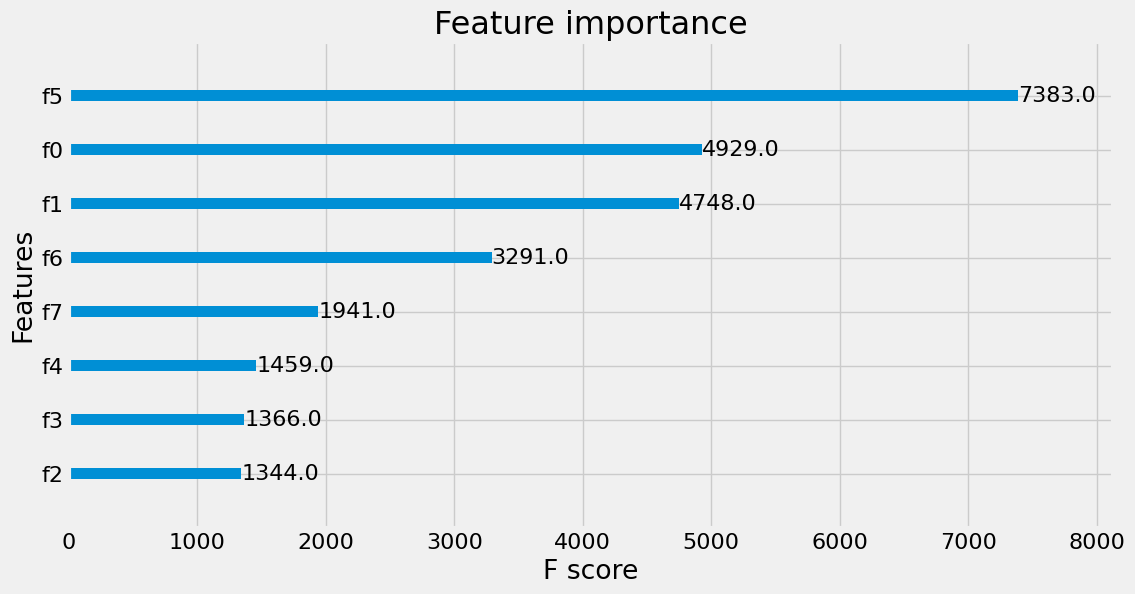

In [75]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')                                   
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(finetuned_regressor , max_num_features=8, ax=ax)
plt.show()

In [52]:
submission6 = np.concatenate([finetuned_regressor.predict(training_x) , finetuned_regressor.predict(testing_x)])
submission6.shape

(44396,)

In [63]:
testing6 = finetuned_regressor.predict(FinalTesting_x) 
testing6.shape

(72158,)

In [ ]:
submission(finetuned_regressor.predict(FinalTesting_x) , 'xgboost.csv')

ENSEMBLING 

In [53]:
submission_df = pd.DataFrame({'submission1' : submission1 , 'submission2' : submission2 , 'submission3' : submission3 ,
                              'submission4' : submission5 , 'submission5' : submission6 , 'actual_y' : actual_y}) 
submission_df.head()

,submission1,submission2,submission3,submission4,submission5,actual_y
0,1412.766937,1029.857143,937.855672,1011.020082,1006.530090,1070.0
1,42.269562,36.033964,40.577866,36.128062,35.189289,41.0
2,48.475712,51.693526,56.453554,55.682295,58.909012,54.0
3,682.955422,630.245902,643.721763,671.054784,669.697449,682.0
4,28.236075,30.328605,35.310315,26.512203,28.401815,30.0


In [64]:
testing_df = pd.DataFrame({'testing1' : testing1 , 'testing2' : testing2 , 'testing3' : testing3 ,
                              'testing4' : testing5 , 'testing5' : testing6}) 
testing_df.shape

(72158, 5)

In [68]:
#Ensemble_Train , Ensemble_Test = train_test_split(submission_df , test_size = 0.2 , random_state = 42) 

Ensemble_Train = submission_df.iloc[:int(0.8*44396)]
Ensemble_Test = submission_df.iloc[int(0.8*44736):]
Ensemble_Train.head()

,submission1,submission2,submission3,submission4,submission5,actual_y
0,1412.766937,1029.857143,937.855672,1011.020082,1006.530090,1070.0
1,42.269562,36.033964,40.577866,36.128062,35.189289,41.0
2,48.475712,51.693526,56.453554,55.682295,58.909012,54.0
3,682.955422,630.245902,643.721763,671.054784,669.697449,682.0
4,28.236075,30.328605,35.310315,26.512203,28.401815,30.0


In [73]:
X_TRAIN = Ensemble_Train.drop(columns = ['actual_y']).values 
X_TEST = Ensemble_Test.drop(columns = ['actual_y']).values 

scaler1 = StandardScaler()
scaler1.fit(X_TRAIN)

scaler2 = StandardScaler() 
scaler2.fit(X_TEST)

X_TRAIN = scaler1.transform(X_TRAIN)
X_TEST = scaler2.transform(X_TEST)

Y_TRAIN = Ensemble_Train['actual_y'].values 
Y_TEST = Ensemble_Test['actual_y'].values 

In [74]:
XGB_REGRESSOR =xgb.XGBRegressor(eval_metric = 'rmse' , learning_rate = 0.015 , max_depth = 7 , n_estimators = 300)
XGB_REGRESSOR.fit(X_TRAIN , Y_TRAIN) 

score = np.sqrt(mean_squared_error(XGB_REGRESSOR.predict(X_TEST) , Y_TEST))
score

82.00911764557759

In [72]:
values = XGB_REGRESSOR.predict(testing_df.values)
values.shape

(72158,)

In [66]:
submission(values , 'ensemble_submission.csv')